Ranging Counter: 0
  Channel 2: [-2.643829]
  Channel 5: [-3.180484]
  Channel 8: [-3.677018]
  Channel 11: [-4.207985]
  Channel 14: [-4.582111]
  Channel 17: [-5.211784]
  Channel 20: [-5.667333]
  Channel 26: [-6.617379]
  Channel 29: [-7.144681]
  Channel 32: [-7.642248]
  Channel 35: [-8.228633]
  Channel 38: [-8.673882]
  Channel 41: [-9.191887]
  Channel 44: [-9.721973]
  Channel 47: [-10.209352]
  Channel 50: [-10.586748]
Ranging Counter: 2
  Channel 2: [-2.666883]
  Channel 5: [-3.242149]
  Channel 8: [-3.75588]
  Channel 11: [-4.300177]
  Channel 14: [-4.761714]
  Channel 17: [-5.363468]
  Channel 20: [-5.702564]
  Channel 26: [-6.68012]
  Channel 29: [-7.209844]
  Channel 32: [-7.688607]
  Channel 35: [-8.291453]
  Channel 38: [-8.722278]
  Channel 41: [-9.274121]
  Channel 44: [-9.746388]
  Channel 47: [-10.353096]
  Channel 50: [-10.801483]
Ranging Counter: 4
  Channel 2: [-2.63134]
  Channel 5: [-3.176274]
  Channel 8: [-3.61793]
  Channel 11: [-4.152966]
  Channel 14: [-

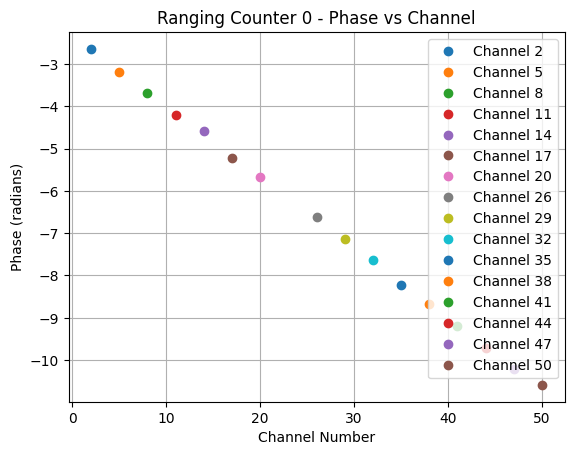

In [2]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import os

# 解析日志的函数
def parse_logs(log_lines):
    # 初始化存储结构
    data = defaultdict(lambda: defaultdict(list))
    current_ranging_counter = None

    # 正则表达式匹配
    ranging_ready_pattern = re.compile(r"I: Ranging data ready (\d+)")
    channel_data_pattern = re.compile(r"I: ch\[(\d+)\] : ([\-\d\.]+) radians")

    # 逐行解析日志
    for line in log_lines:
        # 检查是否是新的探测次数
        ranging_match = ranging_ready_pattern.search(line)
        if ranging_match:
            current_ranging_counter = int(ranging_match.group(1))
            continue

        # 检查是否是信道数据
        channel_match = channel_data_pattern.search(line)
        if channel_match and current_ranging_counter is not None:
            channel = int(channel_match.group(1))
            phase = float(channel_match.group(2))
            # 存储数据
            data[current_ranging_counter][channel].append(phase)

    return data

# 从文件加载日志数据
def load_log_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        log_lines = file.readlines()
    return log_lines

# 绘图函数
def plot_data(parsed_data, ranging_counter):
    if ranging_counter not in parsed_data:
        print(f"No data for ranging counter {ranging_counter}")
        return

    channels = parsed_data[ranging_counter]
    for channel, phases in channels.items():
        plt.plot([channel] * len(phases), phases, 'o', label=f"Channel {channel}")

    plt.xlabel("Channel Number")
    plt.ylabel("Phase (radians)")
    plt.title(f"Ranging Counter {ranging_counter} - Phase vs Channel")
    plt.legend()
    plt.grid()
    plt.show()

# 去除共模的函数
def remove_common_mode(parsed_data):
    # 输出新结构：共模去除后的数据
    denoised_data = defaultdict(lambda: defaultdict(list))
    for ranging_counter, channels in parsed_data.items():
        # 获取所有信道的相位样本（扁平化合并）
        all_phases = []
        for phases in channels.values():
            all_phases.extend(phases)
        if not all_phases:
            continue
        # 计算共模分量（均值）
        common_mode = sum(all_phases) / len(all_phases)
        # 每个信道减去共模
        for channel, phases in channels.items():
            denoised_phases = [phase - common_mode for phase in phases]
            denoised_data[ranging_counter][channel] = denoised_phases
        
        print(f"Ranging {ranging_counter}: common_mode = {common_mode}")
    return denoised_data

# 主函数
if __name__ == "__main__":
    # 替换为你的 txt 文件路径
    # file_path = "far.long.test.txt"
    # file_path = "small.t1.txt"
    # file_path = "close.test.txt"
    # file_path = "far.AT.txt"
    # file_path = "far.AT.slow.walk.txt"
    file_path = "3.6cable.txt"
    file_path = "1mcable.2.txt"
    file_path = "2.6cable.txt"
    file_path_2 = "3.6cable.txt"


    # file_path = "pcd.itv.4.cable.txt"
    # file_path = "cs15ch.txt"
    # file_path = "cs.full.ch.txt"

    base_name = os.path.basename(file_path)         # 得到 '1mcable.2.txt'
    base_name_2 = os.path.basename(file_path_2)         # 得到 '1mcable.2.txt'
    name_only = os.path.splitext(base_name)[0]      # 得到 '1mcable.2'

    # 加载日志文件
    log_lines = load_log_file(file_path)
    log_lines_2 = load_log_file(file_path_2)

    # 解析日志数据
    parsed_data = parse_logs(log_lines)
    parsed_data_2 = parse_logs(log_lines_2)

    # 打印解析结果
    for ranging_counter, channels in parsed_data.items():
        print(f"Ranging Counter: {ranging_counter}")
        for channel, phases in channels.items():
            print(f"  Channel {channel}: {phases}")

    # # 绘制第 0 次信道探测的结果
    plot_data(parsed_data, ranging_counter=0)

    # # 绘制第 1 次信道探测的结果
    # plot_data(parsed_data, ranging_counter=1)

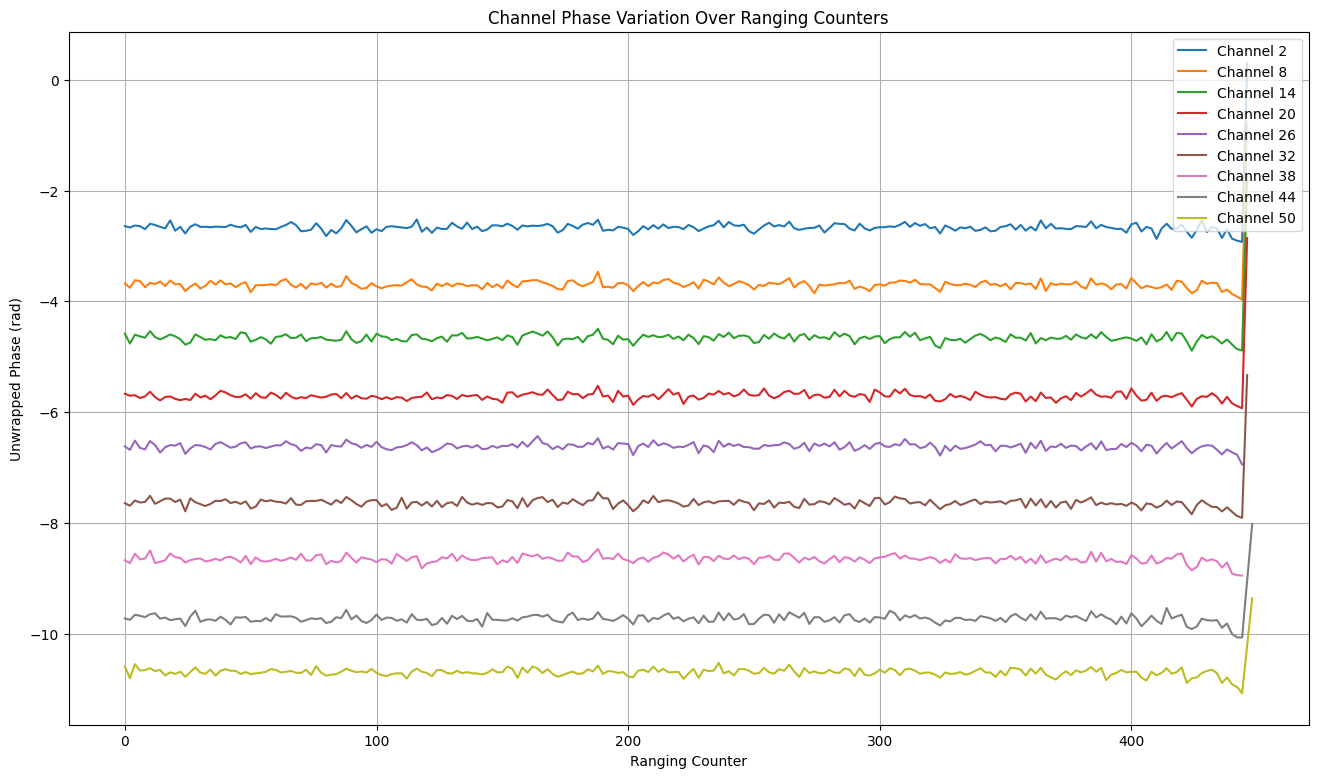

In [3]:
# 计算信道平均相位值的函数
def calculate_channel_averages(parsed_data):
    channel_averages = defaultdict(list)  # 每个信道的平均相位值列表

    # 遍历每次信道探测的结果
    for ranging_counter, channels in parsed_data.items():
        for channel, phases in channels.items():
            # 计算均值并保存
            average_phase = sum(phases) / len(phases)
            channel_averages[channel].append((ranging_counter, average_phase))

    return channel_averages

# 绘制信道变化曲线的函数
def plot_channel_variation(channel_averages, channels_to_plot):
    plt.figure(figsize=(16, 9))

    for channel in channels_to_plot:
        if channel in channel_averages:
            data = channel_averages[channel]
            ranging_counters = [item[0] for item in data]  # 信道探测次数
            average_phases = [item[1] for item in data]    # 平均相位值
            plt.plot(ranging_counters, average_phases, label=f"Channel {channel}")
        else:
            print(f"Channel {channel} not found in the data.")


    plt.xlabel("Ranging Counter")
    plt.ylabel("Unwrapped Phase (rad)")
    plt.title("Channel Phase Variation Over Ranging Counters")
    plt.legend()
    plt.grid()
    plt.savefig(f"./poster.fig/channel_variation_{base_name}.svg", dpi=300)  # 保存图像
    plt.show()


def plot_channel_phase_diff(channel_averages, channels_to_plot):
    """
    画相邻信道的相位差随Ranging Counter的变化曲线。
    """
    plt.figure(figsize=(10, 8))
    for i in range(1, len(channels_to_plot)):
        ch1 = channels_to_plot[i-1]
        ch2 = channels_to_plot[i]
        if ch1 in channel_averages and ch2 in channel_averages:
            # 拿到两个信道的ranging和相位
            data1 = dict(channel_averages[ch1])
            data2 = dict(channel_averages[ch2])
            # 只取两个信道都有数据的counter
            shared_counters = sorted(set(data1.keys()) & set(data2.keys()))
            phase_diffs = [data2[cnt] - data1[cnt] for cnt in shared_counters]
            plt.plot(shared_counters, phase_diffs, label=f"Ch{ch2}-Ch{ch1}")
        else:
            print(f"Channel {ch1} or {ch2} not found in data.")

    plt.xlabel("Ranging Counter")
    plt.ylabel("Phase Difference (radians)")
    plt.title("Adjacent Channel Phase Difference Over Ranging Counters")
    plt.legend()
    plt.grid()
    plt.show()


    # 计算每个信道的平均相位值以去除共模噪声，再进行后续计算
# denoised_data = remove_common_mode(parsed_data)
# channel_averages = calculate_channel_averages(denoised_data)
# 计算每个信道的平均相位值
channel_averages = calculate_channel_averages(parsed_data)
channel_averages_2 = calculate_channel_averages(parsed_data_2)

# 指定要绘制的信道
# channels_to_plot = [2, 10, 20, 30, 40, 50, 60, 70, 76]  # 你可以修改为需要展示的信道
# channels_to_plot = [2,  5,  8,  11, 14, 17, 20, 23, 26, 29, 32,35, 38, 41, 44, 47, 50]  # 你可以修改为需要展示的信道
channels_to_plot = [2,   8,   14,  20,  26,  32, 38,  44,  50]  # 展示的信道pcd.itv.4.cable
# channels_to_plot = [2,   50]  # 展示的信道far.long.test

plot_channel_variation(channel_averages, channels_to_plot)
# plot_channel_phase_diff(channel_averages, channels_to_plot)


上图所示，似乎会有一些随机误差，但又谈不上是随机的，因为每个channel 的变化都是一样的，我可以用这些值滤波吗？

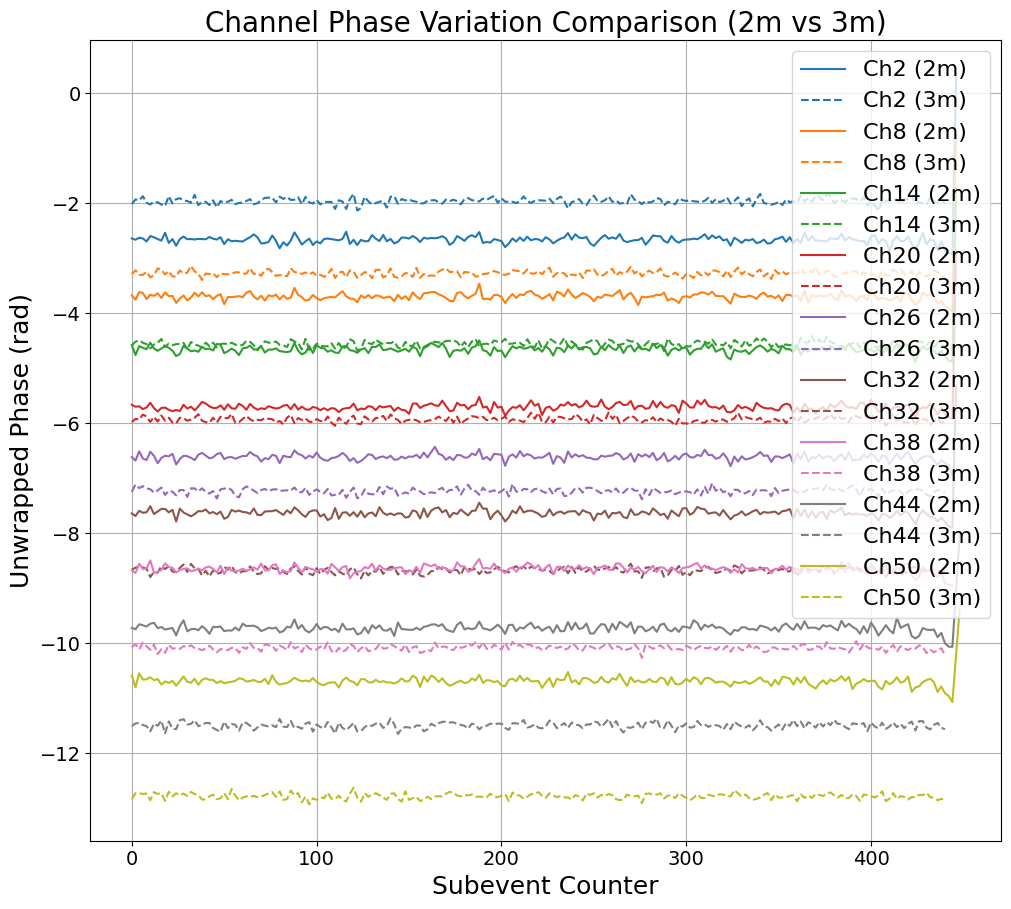

In [11]:
import matplotlib.pyplot as plt

def plot_channel_variation_compare(channel_averages_2, channel_averages_3, channels_to_plot, label_2='2m', label_3='3m'):

    cm=1/2.54  # cm to inch
    pt = 1/72.27  # point to inch
    linewidth = 246*pt
    textwidth = 506*pt  # 0.5 cm in points
    axis_label_size = 18   # 坐标轴标签字体
    title_size = 20        # 图标题字体
    legend_size = 16       # 图例字体
    tick_size = 14         # 坐标轴刻度字体
    scale_size = 3 #缩放倍数
    spine_width = 2 # 边框宽度

    plt.figure(figsize=(scale_size*linewidth, scale_size* 0.9 *linewidth))
    color_map = plt.get_cmap('tab10')  # 可容纳10个不同颜色，够用可扩展

    for idx, channel in enumerate(channels_to_plot):
        color = color_map(idx % 10)
        # 2m 实线
        if channel in channel_averages_2:
            data2 = channel_averages_2[channel]
            x2 = [item[0] for item in data2]
            y2 = [item[1] for item in data2]
            plt.plot(x2, y2, label=f"Ch{channel} ({label_2})", color=color, linestyle='-')
        # 3m 虚线
        if channel in channel_averages_3:
            data3 = channel_averages_3[channel]
            x3 = [item[0] for item in data3]
            y3 = [item[1] for item in data3]
            plt.plot(x3, y3, label=f"Ch{channel} ({label_3})", color=color, linestyle='--')
    
    plt.xlabel("Subevent Counter", fontsize=axis_label_size)
    plt.ylabel("Unwrapped Phase (rad)", fontsize=axis_label_size)
    plt.title("Channel Phase Variation Comparison (2m vs 3m)", fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.legend(fontsize=legend_size)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"./poster.fig/channel_variation_compare_{base_name}_{base_name_2}.svg", dpi=300)  # 保存图像
    plt.show()

# 调用方式不变
plot_channel_variation_compare(channel_averages, channel_averages_2, channels_to_plot, label_2='2m', label_3='3m')